# Lab 1: Probability & Descriptive Statistics

Open in Google Colab: [Link](https://colab.research.google.com/drive/1uhmvrNuajt2x5HhMpDcJlIaRA6dHfU0S?usp=sharing)

Focus: explore core descriptive statistics and dependence concepts using simple synthetic data.

You will:

- Generate and compare a skewed and a roughly normal sample
- Compute mean, variance, sd, skewness, kurtosis
- Compare biased vs unbiased variance estimators
- Examine covariance & correlation (marketing vs revenue)
- Simulate a high-correlation (ρ = 0.90) two-asset return setting
- Study sampling distributions of asset and portfolio means



Alternatively, copy and paste the code below into RStuido Desktop or RStudio Cloud.

## Datasets

Synthetic generators used:

- Right-skewed transaction values (log-normal)
- Approx. normal reference sample
- Two correlated asset return series (ρ = 0.90) for sampling exercises

## Instructions

Run each cell sequentially. Read the comments carefully.


In [36]:
# ---- Setup: packages & helper (updated) ----
# Unified required package list
pkgs <- c("tidyverse", "moments", "knitr", "kableExtra")
missing <- setdiff(pkgs, rownames(installed.packages()))
if (length(missing) > 0) install.packages(missing)

# Load all packages (silently)
invisible(lapply(pkgs, library, character.only = TRUE))

# Set default options for figures in Jupyter Notebook
options(repr.plot.width = 12, repr.plot.height = 4)  # wider default figures

message("Setup complete (packages loaded: ", paste(pkgs, collapse = ", "), ").")

Setup complete (packages loaded: tidyverse, moments, knitr, kableExtra).



## Independence vs. Zero Correlation

Independence means no influence between events, while correlation measures linear relationship strength. 

Independence implies zero correlation, but zero correlation does not imply independence.

E.g., $X$ and $Y = X^2$ have zero correlation but are not independent.

In [37]:
# ---- Zero Correlation but NOT Independence: Y = X^2 ----
# Idea: X ~ N(0,1); define Y = X^2.  Then cor(X,Y) ~ 0 (symmetry cancels linear relation),
# yet Y is a deterministic function of X so they are NOT independent.

set.seed(2025)
n <- 5000
X <- rnorm(n)
Y <- X^2
r_xy <- cor(X, Y)
cat(sprintf("Sample correlation cor(X, Y=X^2) = %.4f (near 0)\n", r_xy))

Sample correlation cor(X, Y=X^2) = 0.0198 (near 0)


We got $\rho_{X,Y}=0.0198$. It seems to be close to zero, but we need a statistical test to confirm this formally. 

→ Test for significance of the correlation coefficient

In [38]:
cor.test(X,Y)


	Pearson's product-moment correlation

data:  X and Y
t = 1.4027, df = 4998, p-value = 0.1608
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.007887062  0.047529726
sample estimates:
       cor 
0.01983657 


--------------------------------------------------------------------------------

💡 **Q: Based on the output of `cor.test`, what is the p-value for the correlation test? What can you conclude about the correlation between the two variables?** Write your answer in the cell below.


A: [Type your answer here]

--------------------------------------------------------------------------------

Now let's visualize $Y=X^2$ by plotting the scatter plot.

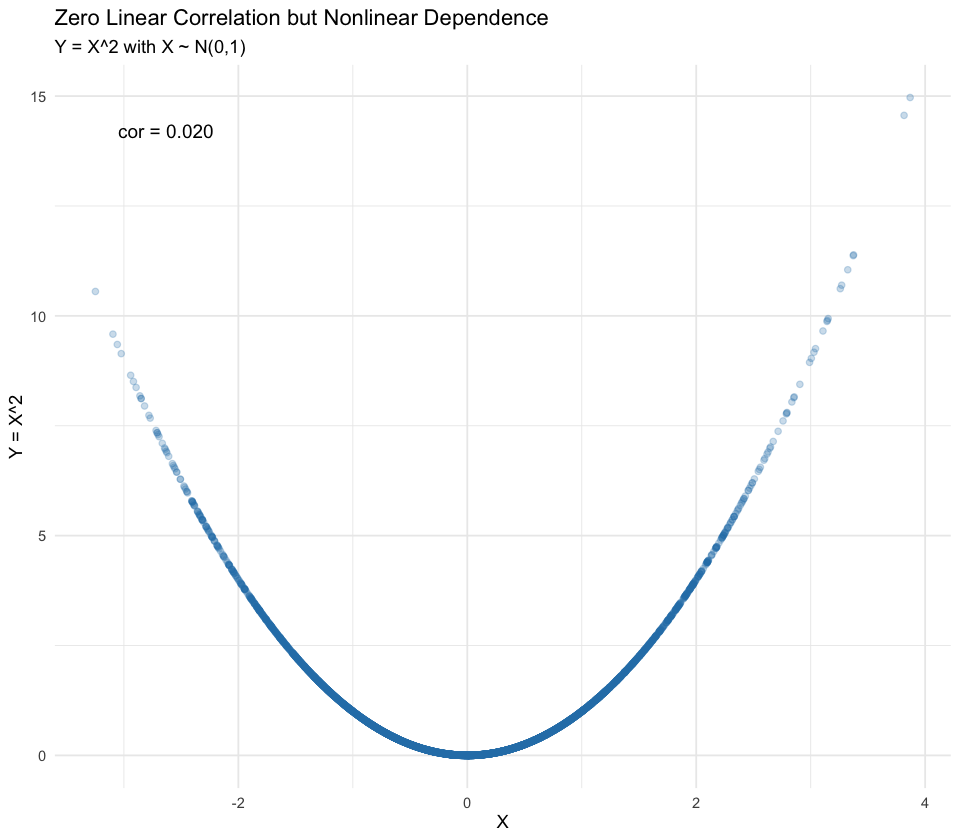

In [39]:
library(ggplot2)
options(repr.plot.width = 8, repr.plot.height = 7)
scatter_df <- data.frame(X = X, Y = Y)
p1 <- ggplot(scatter_df, aes(X, Y)) +
  geom_point(alpha = 0.25, color = '#2c7fb8') +
  annotate('text', x = min(X)+0.2, y = max(Y)*0.95,
           label = paste0('cor = ', sprintf('%.3f', r_xy)),
           hjust = 0, size = 4) +
  labs(title = 'Zero Linear Correlation but Nonlinear Dependence',
       subtitle = 'Y = X^2 with X ~ N(0,1)',
       x = 'X', y = 'Y = X^2') +
  theme_minimal()
print(p1)

## Descriptive Statistics on Asset Returns

In [57]:
# ---- Load Asset Returns Data ----
asset_df <- read_csv("https://raw.githubusercontent.com/my1396/FIN5005-Fall2025/refs/heads/main/data/asset_returns.csv")
print("Preview: first 6 rows of asset returns data frame:")
head(asset_df) %>% round(2)

[1] "Preview: first 6 rows of asset returns data frame:"


Asset_A,Asset_B,Asset_C
<dbl>,<dbl>,<dbl>
17.89,4.31,9.94
10.30,4.17,10.55
20.87,14.16,6.61
18.21,22.33,9.58
17.49,2.23,10.23
29.87,15.72,8.97


We define a summary statistics function to compute the statistics of interest.

In [48]:
quick_summary <- function(x) {
  # Function to compute basic descriptive statistics
  data.frame(
    n = length(x),
    mean = mean(x),
    sd = sd(x),
    var = var(x),
    skewness = moments::skewness(x),
    kurtosis = moments::kurtosis(x),
    row.names = NULL
  )
}

The summary statistic table is generated as follows:

In [58]:
lapply(asset_df, quick_summary) %>%
    do.call(rbind, .) %>%
    kable(digits = 2, caption = "Descriptive Statistics of Asset Returns")



Table: Descriptive Statistics of Asset Returns

|        |     n|  mean|   sd|   var| skewness| kurtosis|
|:-------|-----:|-----:|----:|-----:|--------:|--------:|
|Asset_A | 10000| 20.14| 4.82| 23.24|    -0.10|     3.15|
|Asset_B | 10000|  8.50| 4.44| 19.71|     1.71|     9.19|
|Asset_C | 10000|  9.99| 1.01|  1.01|    -0.85|     3.50|

Plot the histograms of the asset returns to visualize their distributions.

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


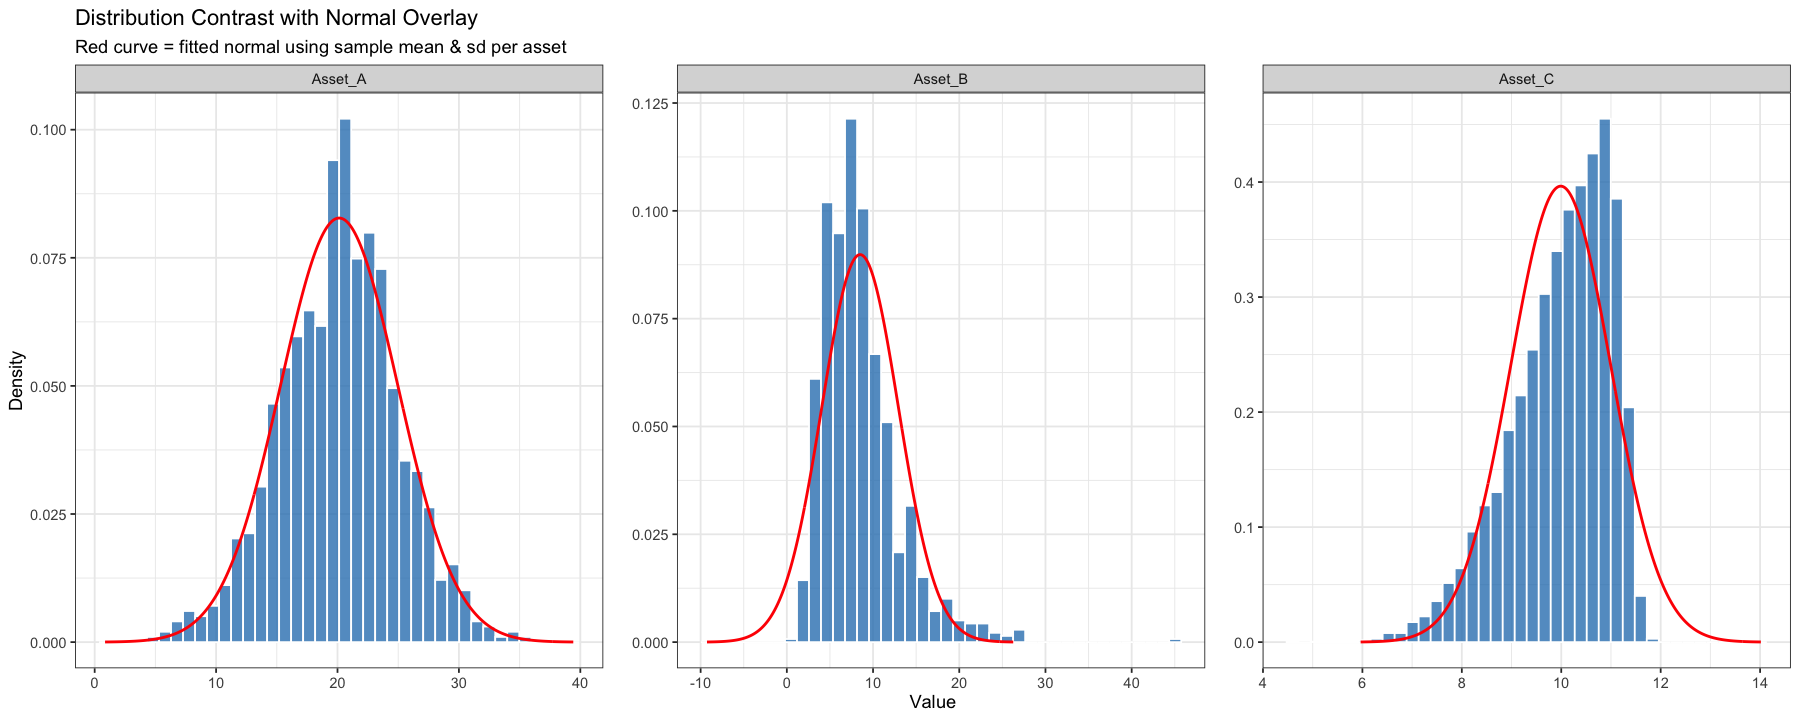

In [56]:
# ---- Visualization: Histograms with Normal Density Overlay ----
# Convert to long form
combined <- asset_df %>% pivot_longer(cols = everything(), names_to = "type", values_to = "value")

# Compute per-type mean & sd and create normal curve points
norm_params <- combined %>% group_by(type) %>% summarise(mu = mean(value), sigma = sd(value), .groups = 'drop')

norm_curve <- norm_params %>% group_by(type) %>% do({
  mu <- .$mu; sigma <- .$sigma
  x <- seq(mu - 4*sigma, mu + 4*sigma, length.out = 400)
  tibble(value = x, density = dnorm(x, mu, sigma))
})

options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(combined, aes(value)) +
  geom_histogram(aes(y = ..density..), bins = 40, fill = "#3182bd", alpha = 0.8, color = "white") +
  geom_line(data = norm_curve, aes(value, density), color = "red", linewidth = 0.8) +
  facet_wrap(~ type, scales = "free", nrow = 1) +
  labs(title = "Distribution Contrast with Normal Overlay",
       subtitle = "Red curve = fitted normal using sample mean & sd per asset",
       x = "Value", y = "Density") +
  theme(panel.spacing.x = unit(1.2, "lines"))

--------------------------------------------------------------------------------

💡 **Q: Answer the following questions based on the summary statistics and the distribution plots:**

- Which asset has the highest mean return?
- Which asset is the most risky? and which one has the most stable returns?
- Which asset shows the positive and what does it mean?
- If an investor prefers assets with low risk and nearly normal returns, which asset is most appropriate?
- Based on mean and standard deviation, which asset has the best risk–return trade-off (highest mean per unit of risk)?


A: [Type your answer here]


---

## Large Sample Gives More Accurate Estimates

We have a variable $X\sim N(0,5^2).$

Now we draw random samples of size 5, 10, 10, ... until 5000 from this distribution and compute the sample mean and standard deviation for each sample.

For each sample, we compute the biased and unbiased sample variance

- The biased sample variance is computed as $$\frac{1}{n}\sum_{i=1}^n (x_i - \bar{x})^2.$$
- The unbiased sample variance is computed as $$\frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})^2$$

In [67]:
# ---- Simulation: Sample vs Population variance ----
set.seed(2025)  # for reproducibility
true_var <- 25  # sd^2 with sd=5, true population variance
sample_sizes <- c(5, 10, 20, 50, 100, 250, 500, 1000, 5000) # varying sample sizes from 5 to 500
results <- lapply(sample_sizes, function(n){
  x <- rnorm(n, mean = 0, sd = 5)
  data.frame("sample_size" = n, "var_biased" = mean((x - mean(x))^2), "var_unbiased" = var(x))
}) %>% dplyr::bind_rows()
cat('Variance estimators: var_n (biased, divide by n) vs var_n1 (unbiased, divide by n-1).\n')
results

Variance estimators: var_n (biased, divide by n) vs var_n1 (unbiased, divide by n-1).


sample_size,var_biased,var_unbiased
<dbl>,<dbl>,<dbl>
5,4.262707,5.328384
10,14.832929,16.481032
20,33.210505,34.958426
50,25.332410,25.849398
100,24.957059,25.209150
250,22.936725,23.028840
500,25.862610,25.914439
1000,25.574182,25.599782
5000,25.301658,25.306719


--------------------------------------------------------------------------------

💡 **Q: Based on the variance estimates for different sample sizes:**

- **As the sample size increases, how do the sample variance estimates compare to the true variance $25$?**
- **Does the sample variance converge to the true variance as the sample size increases?**
- **What is the difference between the biased and unbiased sample variance estimators?**

A: [Type your answer here]

--------------------------------------------------------------------------------

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


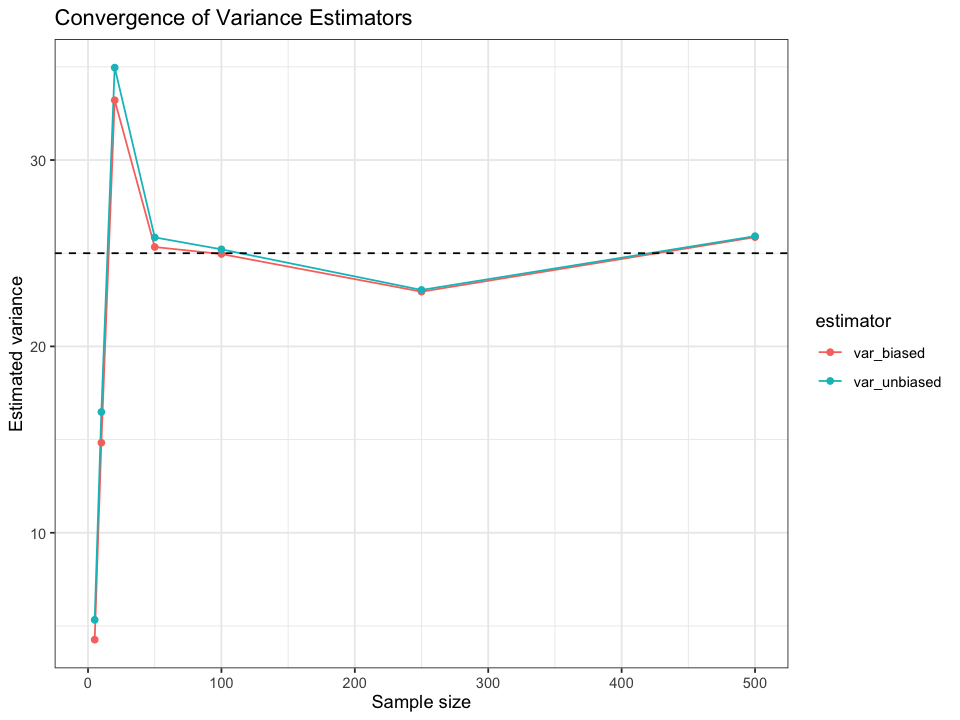

In [76]:
# ---- Plot: Convergence of variance estimators ----
results_long <- results %>%
  tidyr::pivot_longer(var_biased:var_unbiased, names_to = "estimator", values_to = "value") %>%
  dplyr::mutate(estimator = dplyr::recode(estimator, var_n = "Divide by n", var_n1 = "Divide by n-1"))

options(repr.plot.width = 8, repr.plot.height = 6)

ggplot(results_long, aes(sample_size, value, color = estimator)) +
  geom_line() +
  geom_point() +
  geom_hline(yintercept = true_var, linetype = "dashed") +
  xlim(c(0,500)) +
  labs(title = "Convergence of Variance Estimators", y = "Estimated variance", x = "Sample size")

## Correlated Asset Returns
We will simulate repeated samples of two (correlated) asset return series and compare the sampling distributions of their sample means and the distribution of the portfolio mean (equal weights).

In [ ]:
X_demo <- read_csv()
assetA_demo <- X_demo[, 1]
assetB_demo <- X_demo[, 2]

Empirical correlation from demo sample: 0.904 (target rho = 0.90)


`geom_smooth()` using formula = 'y ~ x'


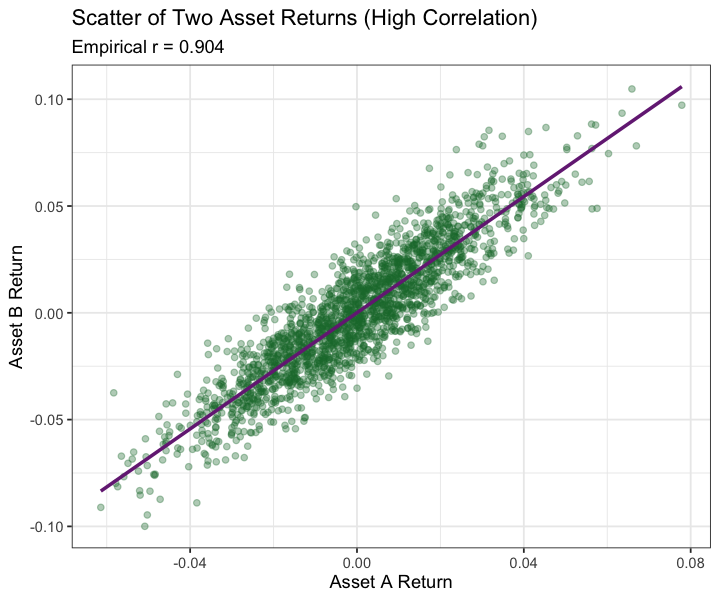

In [ ]:
emp_cor <- cor(assetA_demo, assetB_demo)
cat(sprintf('Empirical correlation from demo sample: %.3f (target rho = %.2f)\n', emp_cor, rho))

options(repr.plot.width = 6, repr.plot.height = 5)

ggplot(data.frame(assetA_demo, assetB_demo), aes(assetA_demo, assetB_demo)) +
  geom_point(alpha = 0.35, color = '#1b7837') +
  geom_smooth(method='lm', se=FALSE, color='#762a83') +
  labs(title = 'Scatter of Two Asset Returns (High Correlation)', x='Asset A Return', y='Asset B Return',
       subtitle = paste0('Empirical r = ', round(emp_cor,3)))

### Reflection

How does correlation between assets influence the portfolio mean's variability? Write 3–4 sentences interpreting for a diversified vs concentrated investment decision.